# Predicting Planting Intentions

## Background
Every year the USDA releases the results of a survey of planting intentions for farmers in the US. Responses are collected the first two weeks of March and released as an aggregate planting value for each state and crop combination. 

This notebook is an attempt to make a rough prediction of what this number may be, given data sources only up to the 29th of March (the day this data is released). 

It is important to note this prediction is done using a combination of previous years' data and current pricing information, and as such will *always* be less accurate than a representative sample of the exact intentions of farmers (as the USDA completes). However, it may give a useful indication of the trend or direction of change. 

## Methodology
There is a multitude of crop-state combinations released in the [USDA ERS](https://app.gro-intelligence.com/dictionary/sources/63) prospective plantings report. In this prototype model, we are focusing on predicting only the corn planted area (in ha), and only in the [corn belt](https://app.gro-intelligence.com/dictionary/regions/100000100). This restriction makes data collection and model optimization more tractable, but the approach would work for a variety of crop-region combinations in the real world.

In [5]:
import os
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats
from IPython.display import display
from api.client.lib import get_default_logger
import pickle

In [6]:
# set up logger. if needed, change the log level in cfg.py 
logger = get_default_logger()

In [7]:
# make the magic happen - import the Gro library
from api.client import Client
api_host = "api.gro-intelligence.com"
client = Client(api_host, os.environ["GROAPI_TOKEN"])

# get the years we have data available:
start_year = 1995
end_year = 2020
num_samples = end_year - start_year

In [8]:
# pull the corn belt states from Gro
state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for 
    state_id 
    in client.lookup('regions', 100000100)["contains"]
}

# resreg = resource region as defined by ers
county_to_resreg = {}
state_to_counties = {}
state_training_data = {}

# get data on the counties in these states
for state_id in state_ids.values():

    state_obj = client.lookup("regions", state_id)
    # the contains field will contain all the next level region data - i.e. counties in this case (aka districts)
    state_to_counties[state_id] = []
    
    # find first county that has an ers region
    for county in state_obj["contains"]:
        
        county_obj = client.lookup("regions", county)
        
        # counties are always level 5
        if county_obj["level"] != 5:
            continue
        
        state_to_counties[state_id].append(county)
        
        for parent_region_obj in client.lookup_belongs("regions", county):
            # resource regions happen to be in this interval of ids
            if parent_region_obj["id"] in range(100000140, 100000149):
                county_to_resreg[county] = parent_region_obj ["id"]
            
        if county not in county_to_resreg:
            logger.error("couldn't find a resreg for county with id %s and name %s in state %s, deleting" % (county, county_information["name"], result["name"]))
            del state_to_counties[state_id][state_to_counties[state_id].index(county)]

## Features

As with any statistical model, we have to collect a number of features of predictor data. Based on domain expertise, we have selected a number of data features available in Gro. The features are grouped by the region granularity that they are available at (country, state, county, and "Ag Districts", which ERS-defined regions grouping counties within states -- e.g. [Alabama Ag District 40](https://app.gro-intelligence.com/dictionary/regions/100000197)), as well as their requisite item, metric pairs for access via Gro. 

In [9]:
def get_all_subitems(item_id):
    # use a set because 
    item_set = set([item_id])
    for sub_item_id in client.lookup("items", item_id)["contains"]:
        item_set |= get_all_subitems(sub_item_id)
    return item_set

In [10]:
# Define the crops we use in the model as predictors.
crop_ids = {
    "corn": 274,
    "soybeans": 270,
    "wheat": 95,
    "cotton": 7077
}
    
crop_ids_expanded = {crop_name: get_all_subitems(crop_id) for (crop_name, crop_id) in crop_ids.iteritems()}

In [11]:
### Format for feature definitions:
# In addition to the usual keys required by get_data_points, we define four custom fields:
# 
# impute: "other_feature_name"       # either the name of a different data series, or just the magic value "impute"
# 
# impute_type: "relative" or "same"  # "relative" does a linear regression with respect
#                                    #  to the "impute" series to impute missing values, 
#                                    # "same" just copies over the missing value for that year
#
# sample_date: (month, year)         # for the given year, the maximum end_date to be sampled, if the 
#                                    # series is more granular than just yearly. i.e. below it picks 
#                                    # the date closest to this date, preceding or on this date.
#
# report_date: (month, year)         # for the given year, the maximum value of "reporting_date" to use to 
#                                    # sample the given the above sample date. mostly useful with futures data which 
#                                    # contains data points with a combination of sample and reporting dates.
# 
# feature_type: "relative"           # "relative" tells us this feature's values are relative to county level features
#                or "absolute"       # and should be normalized in some manner before being used in a linear model
#                                    # at the county level.

features = {
    "country": {
        "futures_price_dec_march": { 
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'sample_date': (12, 31),
            'report_date': (3, 28),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065, 
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "futures_price_dec_june": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'sample_date': (12, 31),
            'report_date': (6, 30),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065,
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "futures_price_dec_nov": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'sample_date': (12, 31),
            'report_date': (11, 10), # bit earlier as some futures don't have december only nov 30 expiration.
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065,  # settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "producer_prices_country_yearly": { # no need to impute - fully downloaded
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "producer_prices_country_march": {
            'impute': "producer_prices_yearly", # impute with yearly values if something's missing.
            'impute_type': "same",
            'sample_date': (3, 31),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 6
        }
    },
    "ers_region": {
        "operating_costs_ers": {
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 15850182, 
            'source_id': 63, 
            'frequency_id': 9
        },
        "overhead_costs_ers": {
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 15850183,
            'source_id': 63, 
            'frequency_id': 9
        },
        "land_opportunity_cost_ers": {
            'impute': 'impute',
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 8591080, 
            'source_id': 63, 
            'frequency_id': 9
        }
    },
    "state": {
        "area_planted_state_march": {
            'feature_type': 'relative',  
            'impute': "area_planted_nass_final_state", 
            'impute_type': "same",
            'report_date': (3, 31),
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "producer_prices_yearly": { 
            'impute': "producer_prices_country_yearly", 
            'impute_type': 'same',
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "producer_prices_march": {
            'impute': "producer_prices_country_march", 
            'impute_type': "same",
            'sample_date': (3, 31),
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 6
        },
        "area_planted_nass_final_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "area_harvested_nass_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 570001, 
            'source_id': 25, 
            'frequency_id': 9,
        }, 
        "production_nass_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 860032, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "yield_nass_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 170037, 
            'source_id': 25, 
            'frequency_id': 9
        }
    },
    "county":{
        "fsa_area_failed_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850168, 
            'source_id': 100, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "fsa_area_failed_non_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850173,
            'source_id': 100, 
            'frequency_id': 9, 
            'show_revisions': True
        },
        "fsa_area_planted_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3280001, 
            'source_id': 100, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "fsa_area_planted_non_irrigated": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3300001,
            'source_id': 100, 
            'frequency_id': 9, 
            'show_revisions': True
        },
        "area_planted_nass_final": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "area_harvested_nass": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 570001, 
            'source_id': 25, 
            'frequency_id': 9,
        }, 
        "production_nass": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 860032, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "yield_nass": {
            'feature_type': 'relative',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 170037, 
            'source_id': 25, 
            'frequency_id': 9
        }
    }
}


In [12]:
# Other data series that could potentially be used in the future.
# Up to the reader to implement.

other_data_series = {
    #yearly, country level
    "interest_rate_us": {
        'level': 3,
        'metric_id': 5020042, 
        'item_id': 4512, 
        'region_id': 1215, 
        'source_id': 25, 
        'frequency_id': 9
    },
    "cpi_us": {
        'metric_id': 950029, 
        'item_id': 4504, 
        'region_id': 1215, 
        'source_id': 6, 
        'frequency_id': 9
    }
}

In [13]:
def get_features_list(features):
    features_list = []
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in crop_ids.keys():
                features_list.append("%s_%s" % (series_name, crop_name))
    return features_list

features_list = get_features_list(features)
num_features = len(features_list)
features_list_pd = pd.DataFrame(features_list)
features_list_pd.columns = ["feature name"]
display(features_list_pd)

,feature name
0,futures_price_dec_june_soybeans
1,futures_price_dec_june_corn
2,futures_price_dec_june_wheat
3,futures_price_dec_june_cotton
4,futures_price_dec_nov_soybeans
5,futures_price_dec_nov_corn
6,futures_price_dec_nov_wheat
7,futures_price_dec_nov_cotton
8,futures_price_dec_march_soybeans
9,futures_price_dec_march_corn


## Data download from Gro API

Gro's data is provided in a "raw" form - that is, minimal post-processing is done in order to allow the end-user the most flexibility in handling the data. Gro does not impute values in the API and provides data in a form as true to the ground truth data as possible.

The data points themselves are provided as simple point-value pairs or triplets. The most basic case of a time-series is simply points associated with a given timestamp. However, in some cases a point is revised or re-released from a source - in this case each point is associated with two time-staps - a "reporting date and an "end date". 

The following code snippet downloads and picks data points from the time series which are relevant to the analysis.

In [ ]:
### IMPORTANT ###
# If you wish to load this data from a saved pickle file, skip this cell and run the next one.
### IMPORANT ###

logger.info("proceeding to download {} features across {} states at a county level".format(num_features, len(state_ids)))

for state_id in state_ids.values():

    num_counties = len(state_to_counties[state_id])
    training_data = np.ma.zeros((num_counties, num_samples, num_features))
    state_training_data[state_id] = training_data
    
    feature_idx = 0
    
    # Get all the crop-specific data series
    for region_type in ["country", "ers_region", "state", "county"]:
        for series_name, query in features[region_type].items():
            for crop_name in crop_ids.keys():
                
                crop_ids_to_check = crop_ids_expanded[crop_name]
                
                for county_idx, county_id in enumerate(state_to_counties[state_id]):
                    
                    # this must be a set because ontology isn't necessarily a tree
                    useful_series = []
                    
                    for crop_id in crop_ids_to_check:
                        
                        query["item_id"] = crop_id

                        if query['level'] == 8:
                            query["region_id"] = county_to_resreg[county_id]
                        elif query['level'] == 5:
                            query['region_id'] = county_id
                        elif query['level'] == 4:
                            query['region_id'] = state_id
                        elif query['level'] == 3:
                            query['region_id'] = 1215

                        result = client.get_data_series(**query)

                        for possible_series in result: 
                            series_start_year = int(possible_series["start_date"][0:4])
                            series_end_year = int(possible_series["end_date"][0:4])
                            if ((series_start_year <= start_year < series_end_year) 
                                                       or (series_start_year < end_year <= series_end_year)
                                                       or (start_year <= series_start_year and series_end_year <= end_year)):
                                useful_series.append(possible_series)
                    
                    if not useful_series:
                        logger.error("NO DATA FOUND FOR %s in %s for %s, county_idx=%i, feature=%i" % 
                              (series_name, state_id, crop_name, county_idx, feature_idx))
                        
                    for series in useful_series:

                        if "show_revisions" in query and query["show_revisions"]:
                            series["show_revisions"] = True

                        # Let's actually download the data
                        data_points = client.get_data_points(**series)
                        number_sample_points = 0

                        cache = np.ma.zeros(num_samples)
                        cache[:] = np.ma.masked

                        for point in data_points:
                            # if we have a sample date specified, let's pick the point that's closest to this point
                            last_sampled_date = None
                            last_reported_date = None
                            sample_deadline = datetime.datetime(int(point["end_date"][0:4]), query["sample_date"][0], query["sample_date"][1]) if "sample_date" in query else None 
                            report_deadline = datetime.datetime(int(point["end_date"][0:4]), query["report_date"][0], query["report_date"][1]) if "report_date" in query else None 
                            if "reporting_date" in point and point["reporting_date"] is not None:
                                reported_date = datetime.datetime.strptime(point["reporting_date"], '%Y-%m-%dT%H:%M:%S.%fZ')
                            else:
                                reported_date = None
                            end_date = datetime.datetime.strptime(point["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ')

                            sample_idx = int(point["end_date"][0:4]) - start_year

                            if 0 <= sample_idx < num_samples:

                                if sample_deadline is not None and end_date > sample_deadline :
                                    # continue to next point as this is after the date we want to grab it.
                                    continue
                                if last_sampled_date is not None and end_date < last_sampled_date:
                                    # newer sample date avail, ignoring this point
                                    continue
                                if report_deadline is not None and reported_date is not None and reported_date > report_deadline:
                                    # past report deadline
                                    continue
                                if last_reported_date is not None and reported_date < last_reported_date:
                                    # newer report date avail
                                    continue
                                
                                # unmask potentially
                                if cache[sample_idx] == np.ma.masked:
                                    cache[sample_idx] = 0.0
                                
                                # some items are item groups and thus need to be sum-aggregated
                                if (last_sampled_date is not None and end_date == last_sampled_date) and (last_reported_date is None or reported_date == last_reported_date):
                                    cache[sample_idx] +=  point["value"]
                                else:
                                    cache[sample_idx] = point["value"]
                                    last_sampled_date = end_date
                                    last_reported_date = reported_date

                                number_sample_points += 1
                    
                        # masked + nonmasked => masked
                        training_data[county_idx, :, feature_idx] += cache

                        logger.debug("downloaded %s in %s for %s, county_idx=%i, num_samples=%i, feature=%i" % 
                              (series_name, state_id, series["item_name"], county_idx, number_sample_points, feature_idx))
                    # if the data we're getting is not county level - use this for all other counties and go to next feature
                    if query["level"] == 4 or query["level"] == 3:
                        logger.debug("copying state or country data to other counties so we don't have to download")
                        training_data[:, :, feature_idx] = training_data[county_idx, :, feature_idx]
                        break

                # download the next feature
                feature_idx += 1

#### uncomment to save this data pull
# pickle.dump(state_training_data, open("state_data.pickle", "wb"))
###

In [14]:
#### uncomment this to load this from a saved state, saving time from the download process.
state_training_data = pickle.load(open("state_data.pickle", "rb"))
###

## Imputation
Gro strives to download data from external providers in an accurate and timely fashion. However, this data will always have some noise at the source - some counties won't report numbers if the planted area that year is too small and some sources will have small inconsistencies or missing reports. To account for this, we fill in the data using three imputation strategies:

- **"same"** - copying the value from a reference data series. If the state-level producer price is not available for a crop, we can relatively safely copy over the country-level price. 
- **"relative"** - doing a linear regression with regards to a different data series. By making the big assumption that this variables correlates linearly with the reference variable, we impute values by fitting a linear function then making the necessary predictions. This works relatively well in cases such as a county's planted area imputed from a state measure of planted area (thus making the assumption that the county's area remains at the same proportion of the state area across years). 
- **"impute"** - here we simply fill in values given the sample average across time for that region. 

In [15]:
### different strategies to impute things with missing values.

imputed_state_training_data = {}

logger.info("starting imputation of data.")

for name, state_id in state_ids.items():
    training_data = state_training_data[state_id]

    training_data = training_data.copy()
    imputed_state_training_data[state_id] = training_data
    feature_idx = -1
    
    # Get all the crop-specific data series info
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in crop_ids.keys():
                feature_idx += 1
                if "impute" not in series:
                        continue

                # "impute" is a magic value where we don't have a reference dataseries
                if series["impute"] != "impute":
                    reference_name = series["impute"] + "_" + crop_name
                    reference_idx = features_list.index(reference_name)

                # case: copy over the values from somewhere else (e.g. state to county prices)
                if "impute_type" in series and series["impute_type"] == "same":
                    logger.debug("doing copying of values for  {}".format(features_list[feature_idx]))
                    training_data[:, :, feature_idx][training_data.mask[:, :, feature_idx]] = \
                    training_data[:, :, reference_idx][training_data.mask[:, :, feature_idx]]
                # case: do a 1-variable regression with regards to some reference timeseries to impute the values.
                elif "impute_type" in series and series["impute_type"] == "relative":
                    logger.debug("doing regression  {}".format(features_list[feature_idx]))
                    for county_idx in range(len(state_to_counties[state_id])):
                        invalid_idxs = training_data.mask[county_idx, :, feature_idx]
                        if not np.any(invalid_idxs):
                            continue
                        valid_idxs = ~invalid_idxs
                        if not np.any(valid_idxs):
                            training_data[county_idx, :, feature_idx] = 0.0
                            continue
                        reg = LinearRegression().fit(training_data[county_idx, valid_idxs, reference_idx].reshape(-1, 1), 
                                                     training_data[county_idx, valid_idxs, feature_idx].reshape(-1, 1))
                        imputed_vals = reg.predict(training_data[county_idx, invalid_idxs, reference_idx].reshape(-1, 1))
                        training_data[county_idx, invalid_idxs, feature_idx] = imputed_vals[:,0]
                # case: take the mean for that *county* across all years (sample expected value over time) and use that to impute missing values
                else:
                    #just naively impute it
                    training_data_avgs = np.ma.repeat(np.expand_dims(training_data.mean(axis=0), axis=0), training_data.shape[-3], axis=0)
                    if np.any(training_data.mask[:,:,feature_idx]):
                        logger.debug("doing naive filling for  {} for {}/{} values".format((features_list[feature_idx]), np.count_nonzero(training_data.mask[:,:,feature_idx]), training_data.mask[:,:,feature_idx].size))
                    training_data[:, :, feature_idx] = np.ma.where(training_data.mask, training_data_avgs, training_data)[:, :, feature_idx]
logger.info("done imputing values.")

starting imputation of data.
done imputing values.


## Feature Data

At this point we are ready to generate our final feature data, which will take the form of 

- **X**: an ndarray of shape *(county, year, number_of_features)* 
    where number_of_features is (number of features for that year + number of features for previous year) as defined in the list "curr_year_features". contains the values of this (county, year, feature) combination
- **y**: an ndarray of shape *(county, year)* containing the planted area in hectares for that county and year.

To generate X , we refer the list of features in **curr_year_features** and **prev_year_features**, which define the features available to us this year and last year. This is relevant to information available at a given time. In this example, we are modelling the planted area from the information we know in March of the current year. Thus, the current year data only includes futures prices and producer prices from march. 

Furthermore, we implement two options for generating the feature data:
- __yoy__: when enabled, this flag creates data to model the year-on-year change, as opposed to the exact planted area.
- __norm_rel_features__: when enabled, this flag will normalize state and country level features with the county's previous planted area, without which we couldn't use hiearchial features in a linear model. 

In [178]:
# generate our X, y for training models on

FLAGS = { 
    "type": "ratio",     # "ratio": model the year-over-year ratio (y(t+1)/y(t))
                         # "delta": model the year-over-year delta (y(t+1) - y(t))
    "minimum_area": 1000 # minimum area in hectares for a county to be included in training data. 
                         # if area < minimum_area, we simply predict the average for the county as 
                         # it's likely an outlier. 
                         # MUST BE >0 if FLAG["type"]=="ratio"
}

logger.info("generating X, y")

X = None
y = None
# store the original actual area planted since we're dealing with deltas and ratios.
area_planted = None
# given we're placing everything in one array, 
# let's store the individual state indices for predictions
state_indices = {}

# the features, by name, we want to use for current and previous year, respectively.
curr_year_features = []
curr_year_features += ["futures_price_dec_march_{}".format(crop_name) for crop_name in crop_ids.keys()]
curr_year_features += ["producer_prices_march_{}".format(crop_name) for crop_name in crop_ids.keys()]
prev_year_features = features_list

X = np.zeros((0, num_samples-1, len(curr_year_features) + len(prev_year_features)))
y = np.zeros((0, num_samples-1))
y_full_area = np.zeros((0, num_samples-1))

for name, state_id in state_ids.items():

    training_data = np.array(imputed_state_training_data[state_id], copy=True)        

    # generate our y
    y_feature_index = features_list.index("area_planted_nass_final_corn")
    test_data = np.array(training_data[:, :, y_feature_index], copy=True)
    test_data_full = np.array(training_data[:, :, y_feature_index], copy=True)
    
    y_full_area = np.concatenate([y_full_area, test_data_full[:,1:]], axis=0)
    
    if FLAGS["type"] == "delta":
        test_data -= np.roll(test_data, 1, axis=1)
    elif FLAGS["type"] == "ratio":
        # we use +1 here for smoothing. We are allowed to do this because any district 
        # that _ever_ has < min area will be replaced using minimum area. Thus 0 acre 
        # districts don't cause an error, and the rest of them will experience a rounding 
        # error's worth of difference.
        test_data = test_data/(np.roll(test_data, 1, axis=1) + 1)
    
    # the first entry is not valid anymore in the test data because of our roll()
    test_data = test_data[:,1:]
    y = np.concatenate([y, test_data], axis=0)
    
    # weight relative features with production quantities for that county for the last year.
    # if modeling ratio we should weight the non-relative features.
    feature_idx = 0
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in crop_ids.keys():
                area_planted_index = features_list.index("area_planted_nass_final_" + 
                                                             crop_name)
                if FLAGS["type"] == "delta" and ("feature_type" in series and series["feature_type"] == "relative"):
                    training_data[:, :, feature_idx] *= np.roll(training_data[:, :, area_planted_index], 1, axis=1)
                elif FLAGS["type"] == "ratio" and not ("feature_type" in series and series["feature_type"] == "relative"):
                    training_data[:, :, feature_idx] *= np.roll(training_data[:, :, area_planted_index], 1, axis=1)
                feature_idx += 1
        
    # pull out the features idxs for the features we are interested in
    curr_year_feature_idxs = [features_list.index(feature_name) for feature_name in curr_year_features]
    prev_year_feature_idxs = [features_list.index(feature_name) for feature_name in prev_year_features]

    # shift us one full year so we never happen to use out-of-sample data
    train_data = np.concatenate((np.roll(training_data, -1, axis=1)[:, :-1, curr_year_feature_idxs],
                                training_data[:, :-1, prev_year_feature_idxs]), axis=2)
    
    logger.debug("saving outputs for state: {}".format(name))
    
    state_index_map[state_id] = (X.shape[0], X.shape[0] + train_data.shape[0])
    X = np.concatenate([X, train_data], axis=0)

logger.info("training, test data matrices generated for all states.")

generating X, y
training, test data matrices generated for all states.


## Model

Now that we have our X and y we fit a linear regression to the problem at a county level. To achieve this, we flatten the X and y arrays to treat each county/year as an I.I.D. sample and fit a linear model to the problem. 

We then use this linear model to predict individual county planted area values and visualize these using choropleths. We evaluate the model by doing a 'leave one out' approach where we model each year using only data from the other years in our dataset. We compare the performance to a simple baseline of just extrapolating the planted area from the previous two years. 


In [114]:
import geopandas
import pandas as pd
import os
from shapely.geometry import shape

###
### GeoDataFrame has no simple support for loading a dict-of-json in python. Used workaround from here:
### https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe
###

gdf = geopandas.GeoDataFrame()

for state_id in state_ids.values():
    for county_id in state_to_counties[state_id]:
        geojson = client.get_geojson(county_id)
        geojson["geometries"] = shape(geojson["geometries"][0])
        new_gdf = geopandas.GeoDataFrame(geojson).set_geometry("geometries")
        new_gdf["district_id"] = county_id
        # TODO: currently we ignore any secondary polygons that are separate from the main 
        # county polygon. figure out how to add these to the same geodataframe
        gdf = pd.concat([gdf, new_gdf.iloc[[0]]])
df_district = gdf

doing prediction for 1996 from 1995
model fitted. score is: 0.128945
our solution was 0.957575 as close as a naive extrapolation from y-1, y-2
RMSE: 695451.129403 (vs naive extrapolation RMSE of 726262.860867)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,1996,South Dakota,18101,-1019249,171763,1037350,102,False
1,1996,Iowa,178553,41062,238099,137491,335,True
2,1996,Kansas,-131021,-1206257,-83280,1075236,89,True
3,1996,Minnesota,11859,-521981,190676,533839,102,False
4,1996,Illinois,53523,-241841,113272,295364,122,False
5,1996,Nebraska,279190,-949378,100597,1228568,129,False
6,1996,Missouri,-46769,-556238,125768,509468,92,True
7,1996,Indiana,130153,-120736,103344,250889,208,False
8,1996,Ohio,40730,-180003,19066,220733,123,False
9,1996,Wisconsin,80264,-496418,18135,576682,116,False


doing prediction for 1997 from 1996
model fitted. score is: 0.111075
our solution was 0.293002 as close as a naive extrapolation from y-1, y-2
RMSE: 156892.239831 (vs naive extrapolation RMSE of 535464.002590)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,1997,South Dakota,171313,265308,1019249,93994,35,True
1,1997,Iowa,70735,404686,-41062,333950,83,True
2,1997,Kansas,102668,141729,1206257,39061,28,True
3,1997,Minnesota,111070,248282,521981,137212,55,True
4,1997,Illinois,-5110,40469,241841,45579,113,False
5,1997,Nebraska,165417,227910,949378,62493,27,True
6,1997,Missouri,23711,323835,556238,300124,93,True
7,1997,Indiana,58935,-20923,120736,79858,382,False
8,1997,Ohio,-6213,-60719,180003,54506,90,True
9,1997,Wisconsin,44512,50461,496418,5949,12,True


doing prediction for 1998 from 1997
model fitted. score is: 0.120505
our solution was 0.305769 as close as a naive extrapolation from y-1, y-2
RMSE: 84893.770845 (vs naive extrapolation RMSE of 277640.468956)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,1998,South Dakota,142854,53550,-265308,89305,167,True
1,1998,Iowa,-18765,-40469,-404686,21704,54,True
2,1998,Kansas,149438,60703,-141729,88735,146,True
3,1998,Minnesota,-11676,124587,-248282,136263,109,False
4,1998,Illinois,116319,242811,-40469,126492,52,True
5,1998,Nebraska,202182,80012,-227910,122170,153,True
6,1998,Missouri,9104,81172,-323835,72069,89,True
7,1998,Indiana,116096,101292,20923,14804,15,True
8,1998,Ohio,47781,19426,60719,28355,146,True
9,1998,Wisconsin,51936,45708,-50461,6228,14,True


doing prediction for 1999 from 1998
model fitted. score is: 0.120602
our solution was 0.617981 as close as a naive extrapolation from y-1, y-2
RMSE: 122699.210219 (vs naive extrapolation RMSE of 198548.602123)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,1999,South Dakota,87233,265841,-53550,178608,67,True
1,1999,Iowa,-21020,161874,40469,182894,113,False
2,1999,Kansas,164980,121406,-60703,43574,36,True
3,1999,Minnesota,-45284,42059,-124587,87343,208,False
4,1999,Illinois,-92561,-0,-242811,92561,178546582274310688,True
5,1999,Nebraska,198697,202930,-80012,4233,2,True
6,1999,Missouri,-126012,120775,-81172,246787,204,False
7,1999,Indiana,59687,809,-101292,58878,7275,True
8,1999,Ohio,39728,81773,-19426,42045,51,True
9,1999,Wisconsin,50245,81054,-45708,30809,38,True


doing prediction for 2000 from 1999
model fitted. score is: 0.124270
our solution was 0.493485 as close as a naive extrapolation from y-1, y-2
RMSE: 93710.115946 (vs naive extrapolation RMSE of 189894.393761)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2000,South Dakota,26827,115612,-265841,88785,77,True
1,2000,Iowa,-146121,-40469,-161874,105653,261,True
2,2000,Kansas,157136,40469,-121406,116668,288,True
3,2000,Minnesota,-49264,120390,-42059,169653,141,False
4,2000,Illinois,-75761,-40469,0,35292,87,True
5,2000,Nebraska,186568,140119,-202930,46449,33,True
6,2000,Missouri,-71851,-99549,-120775,27698,28,True
7,2000,Indiana,77327,-40896,-809,118222,289,False
8,2000,Ohio,23454,-61044,-81773,84498,138,False
9,2000,Wisconsin,47022,80045,-81054,33022,41,True


doing prediction for 2001 from 2000
model fitted. score is: 0.128581
our solution was 0.854666 as close as a naive extrapolation from y-1, y-2
RMSE: 107684.687447 (vs naive extrapolation RMSE of 125996.189582)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2001,South Dakota,-29928,42823,-115612,72751,170,False
1,2001,Iowa,-136525,121406,40469,257931,212,False
2,2001,Kansas,83513,-38330,-40469,121843,318,False
3,2001,Minnesota,-27031,-162,-120390,26869,16599,True
4,2001,Illinois,-60691,80937,40469,141628,175,False
5,2001,Nebraska,110800,120758,-140119,9958,8,True
6,2001,Missouri,-8176,-82006,99549,73830,90,True
7,2001,Indiana,71891,40977,40896,30914,75,True
8,2001,Ohio,24302,60241,61044,35940,60,True
9,2001,Wisconsin,46610,19862,-80045,26748,135,True


doing prediction for 2002 from 2001
model fitted. score is: 0.128650
our solution was 1.379340 as close as a naive extrapolation from y-1, y-2
RMSE: 102439.100130 (vs naive extrapolation RMSE of 74266.757504)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2002,South Dakota,44851,-98367,-42823,143218,146,False
1,2002,Iowa,-211401,-222577,-121406,11176,5,True
2,2002,Kansas,153071,-41702,38330,194773,467,False
3,2002,Minnesota,-106896,-43662,162,63234,145,True
4,2002,Illinois,-97463,-40469,-80937,56995,141,True
5,2002,Nebraska,76700,-100254,-120758,176954,177,False
6,2002,Missouri,19496,40325,82006,20830,52,True
7,2002,Indiana,58270,81306,-40977,23036,28,True
8,2002,Ohio,8997,61164,-60241,52167,85,True
9,2002,Wisconsin,39684,-24499,-19862,64184,262,False


doing prediction for 2003 from 2002
model fitted. score is: 0.131872
our solution was 1.232483 as close as a naive extrapolation from y-1, y-2
RMSE: 137671.651425 (vs naive extrapolation RMSE of 111702.645289)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2003,South Dakota,56400,1294,98367,55106,4260,True
1,2003,Iowa,-78970,60703,222577,139672,230,False
2,2003,Kansas,100342,-59532,41702,159874,269,False
3,2003,Minnesota,-2947,121148,43662,124095,102,False
4,2003,Illinois,18752,-121406,40469,140158,115,False
5,2003,Nebraska,45007,-59590,100254,104597,176,False
6,2003,Missouri,41740,-19126,-40325,60866,318,False
7,2003,Indiana,79398,-143297,-81306,222695,155,False
8,2003,Ohio,22495,-181980,-61164,204475,112,False
9,2003,Wisconsin,53580,71974,24499,18394,26,True


doing prediction for 2004 from 2003
model fitted. score is: 0.120458
our solution was 0.488884 as close as a naive extrapolation from y-1, y-2
RMSE: 51415.239723 (vs naive extrapolation RMSE of 105168.538682)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2004,South Dakota,25456,-44438,-1294,69894,157,False
1,2004,Iowa,-254425,-161874,-60703,92551,57,True
2,2004,Kansas,117677,72105,59532,45571,63,True
3,2004,Minnesota,-113025,-82714,-121148,30310,37,True
4,2004,Illinois,-129471,-141640,121406,12169,9,True
5,2004,Nebraska,110139,99910,59590,10229,10,True
6,2004,Missouri,30527,-1931,19126,32458,1681,False
7,2004,Indiana,51788,41705,143297,10083,24,True
8,2004,Ohio,22199,60579,181980,38380,63,True
9,2004,Wisconsin,35801,-48508,-71974,84309,174,False


doing prediction for 2005 from 2004
model fitted. score is: 0.124207
our solution was 0.650238 as close as a naive extrapolation from y-1, y-2
RMSE: 105419.914606 (vs naive extrapolation RMSE of 162125.089812)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2005,South Dakota,56844,-100356,44438,157200,157,False
1,2005,Iowa,-103901,-60703,161874,43198,71,True
2,2005,Kansas,108643,49455,-72105,59188,120,True
3,2005,Minnesota,-64327,-161947,82714,97619,60,True
4,2005,Illinois,4202,-182109,141640,186311,102,False
5,2005,Nebraska,79910,-40169,-99910,120079,299,False
6,2005,Missouri,75370,-20168,1931,95539,474,False
7,2005,Indiana,52380,-61586,-41705,113966,185,False
8,2005,Ohio,14801,19934,-60579,5133,26,True
9,2005,Wisconsin,20099,4289,48508,15811,369,True


doing prediction for 2006 from 2005
model fitted. score is: 0.124733
our solution was 0.938284 as close as a naive extrapolation from y-1, y-2
RMSE: 71579.947032 (vs naive extrapolation RMSE of 76288.136359)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2006,South Dakota,56914,23637,100356,33276,141,True
1,2006,Iowa,-2417,40469,60703,42886,106,False
2,2006,Kansas,90603,101862,-49455,11259,11,True
3,2006,Minnesota,-19023,182009,161947,201031,110,False
4,2006,Illinois,180822,242811,182109,61989,26,True
5,2006,Nebraska,115764,141426,40169,25662,18,True
6,2006,Missouri,59512,82683,20168,23171,28,True
7,2006,Indiana,85263,122728,61586,37465,31,True
8,2006,Ohio,29622,61352,-19934,31730,52,True
9,2006,Wisconsin,33384,16021,-4289,17363,108,True


doing prediction for 2007 from 2006
model fitted. score is: 0.127843
our solution was 1.553385 as close as a naive extrapolation from y-1, y-2
RMSE: 463332.868131 (vs naive extrapolation RMSE of 298273.060692)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2007,South Dakota,24522,-286580,-23637,311102,109,False
1,2007,Iowa,77450,-607028,-40469,684478,113,False
2,2007,Kansas,72144,-201940,-101862,274084,136,False
3,2007,Minnesota,-21848,-413583,-182009,391736,95,True
4,2007,Illinois,76999,-728434,-242811,805433,111,False
5,2007,Nebraska,110676,-477236,-141426,587912,123,False
6,2007,Missouri,107957,-182761,-82683,290719,159,False
7,2007,Indiana,96437,-367495,-122728,463933,126,False
8,2007,Ohio,29818,-162796,-61352,192614,118,False
9,2007,Wisconsin,47088,-100172,-16021,147261,147,False


doing prediction for 2008 from 2007
model fitted. score is: 0.112326
our solution was 1.514990 as close as a naive extrapolation from y-1, y-2
RMSE: 214649.032008 (vs naive extrapolation RMSE of 141683.437877)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2008,South Dakota,115141,356023,286580,240882,68,True
1,2008,Iowa,125888,445154,607028,319266,72,True
2,2008,Kansas,117131,253022,201940,135891,54,True
3,2008,Minnesota,45479,284316,413583,238837,84,True
4,2008,Illinois,89025,364889,728434,275864,76,True
5,2008,Nebraska,131514,416948,477236,285434,68,True
6,2008,Missouri,34769,202140,182761,167371,83,True
7,2008,Indiana,84223,265578,367495,181355,68,True
8,2008,Ohio,35253,103353,162796,68100,66,True
9,2008,Wisconsin,36308,82832,100172,46524,56,True


doing prediction for 2009 from 2008
model fitted. score is: 0.127445
our solution was 0.289821 as close as a naive extrapolation from y-1, y-2
RMSE: 97186.201235 (vs naive extrapolation RMSE of 335331.700278)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2009,South Dakota,134786,58995,-356023,75791,128,True
1,2009,Iowa,69315,-60703,-445154,130018,214,False
2,2009,Kansas,105001,171960,-253022,66959,39,True
3,2009,Minnesota,43184,63448,-284316,20264,32,True
4,2009,Illinois,189740,81075,-364889,108664,134,True
5,2009,Nebraska,167492,-40453,-416948,207945,514,False
6,2009,Missouri,51102,60446,-202140,9344,15,True
7,2009,Indiana,93450,-324,-265578,93774,28965,False
8,2009,Ohio,55268,17333,-103353,37934,219,True
9,2009,Wisconsin,47908,8673,-82832,39235,452,True


doing prediction for 2010 from 2009
model fitted. score is: 0.124450
our solution was 0.714345 as close as a naive extrapolation from y-1, y-2
RMSE: 104838.461727 (vs naive extrapolation RMSE of 146761.767399)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2010,South Dakota,42897,-30570,-58995,73467,240,False
1,2010,Iowa,91460,80937,60703,10523,13,True
2,2010,Kansas,54285,250148,-171960,195863,78,True
3,2010,Minnesota,-52892,80473,-63448,133365,166,False
4,2010,Illinois,45010,-120315,-81075,165326,137,False
5,2010,Nebraska,134172,140535,40453,6363,5,True
6,2010,Missouri,-19213,-82583,-60446,63371,77,True
7,2010,Indiana,82378,-40503,324,122881,303,False
8,2010,Ohio,41485,19904,-17333,21581,108,True
9,2010,Wisconsin,40974,4920,-8673,36055,733,True


doing prediction for 2011 from 2010
model fitted. score is: 0.137968
our solution was 5.181078 as close as a naive extrapolation from y-1, y-2
RMSE: 437223.814355 (vs naive extrapolation RMSE of 84388.583410)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2011,South Dakota,225840,-45639,30570,271479,595,False
1,2011,Iowa,580454,-182109,-80937,762563,419,False
2,2011,Kansas,247519,-122138,-250148,369658,303,False
3,2011,Minnesota,271565,-125336,-80473,396901,317,False
4,2011,Illinois,644571,-59647,120315,704219,1181,False
5,2011,Nebraska,366974,-102425,-140535,469398,458,False
6,2011,Missouri,270196,77022,82583,193174,251,True
7,2011,Indiana,340301,-13155,40503,353457,2687,False
8,2011,Ohio,237561,-22517,-19904,260078,1155,False
9,2011,Wisconsin,118052,-8911,-4920,126963,1425,False


doing prediction for 2012 from 2011
model fitted. score is: 0.133478
our solution was 1.706178 as close as a naive extrapolation from y-1, y-2
RMSE: 198821.629304 (vs naive extrapolation RMSE of 116530.437728)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2012,South Dakota,125890,258702,45639,132812,51,True
1,2012,Iowa,340961,-0,182109,340961,520681020662703104,False
2,2012,Kansas,56019,5606,122138,50413,899,True
3,2012,Minnesota,100851,-34732,125336,135583,390,False
4,2012,Illinois,368281,37513,59647,330768,882,True
5,2012,Nebraska,264831,61120,102425,203711,333,True
6,2012,Missouri,125058,20248,-77022,104809,518,True
7,2012,Indiana,203958,-62088,13155,266046,428,False
8,2012,Ohio,104831,24325,22517,80506,331,True
9,2012,Wisconsin,72036,35563,8911,36472,103,True


doing prediction for 2013 from 2012
model fitted. score is: 0.118879
our solution was 1.111046 as close as a naive extrapolation from y-1, y-2
RMSE: 141900.996705 (vs naive extrapolation RMSE of 127718.429554)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2013,South Dakota,-66841,-48637,-258702,18204,37,True
1,2013,Iowa,187073,-20234,0,207307,1025,False
2,2013,Kansas,20033,-153626,-5606,173659,113,False
3,2013,Minnesota,2580,-133484,34732,136064,102,False
4,2013,Illinois,335703,182139,-37513,153565,84,True
5,2013,Nebraska,60846,-102543,-61120,163389,159,False
6,2013,Missouri,-37532,100844,-20248,138376,137,False
7,2013,Indiana,162883,6057,62088,156826,2589,True
8,2013,Ohio,39549,-44038,-24325,83587,190,False
9,2013,Wisconsin,41015,-50492,-35563,91506,181,False


doing prediction for 2014 from 2013
model fitted. score is: 0.123402
our solution was 0.828231 as close as a naive extrapolation from y-1, y-2
RMSE: 122001.980535 (vs naive extrapolation RMSE of 147304.311124)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2014,South Dakota,17261,206454,48637,189194,92,True
1,2014,Iowa,61918,222577,20234,160659,72,True
2,2014,Kansas,98592,162201,153626,63609,39,True
3,2014,Minnesota,55089,260352,133484,205262,79,True
4,2014,Illinois,-3237,122362,-182139,125599,103,False
5,2014,Nebraska,116012,243387,102543,127374,52,True
6,2014,Missouri,-73995,-16509,-100844,57486,348,True
7,2014,Indiana,70066,106814,-6057,36747,34,True
8,2014,Ohio,42213,81775,44038,39562,48,True
9,2014,Wisconsin,30865,84169,50492,53304,63,True


doing prediction for 2015 from 2014
model fitted. score is: 0.131468
our solution was 0.713423 as close as a naive extrapolation from y-1, y-2
RMSE: 157974.015431 (vs naive extrapolation RMSE of 221430.948900)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2015,South Dakota,-108070,18082,-206454,126152,698,False
1,2015,Iowa,-66012,-458,-222577,65553,14301,True
2,2015,Kansas,-113020,-24007,-162201,89013,371,True
3,2015,Minnesota,-141448,108146,-260352,249594,231,False
4,2015,Illinois,-93024,-2547,-122362,90477,3553,True
5,2015,Nebraska,82940,-43907,-243387,126847,289,False
6,2015,Missouri,9726,-352061,16509,361787,103,False
7,2015,Indiana,99869,38234,-106814,61635,161,True
8,2015,Ohio,18543,19033,-81775,490,3,True
9,2015,Wisconsin,23504,36175,-84169,12672,35,True


doing prediction for 2016 from 2015
model fitted. score is: 0.127168
our solution was 1.747917 as close as a naive extrapolation from y-1, y-2
RMSE: 139024.711225 (vs naive extrapolation RMSE of 79537.344700)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2016,South Dakota,-34876,-13506,-18082,21370,158,True
1,2016,Iowa,-3299,-141182,458,137883,98,True
2,2016,Kansas,50346,66817,24007,16471,25,True
3,2016,Minnesota,-147546,-35015,-108146,112531,321,True
4,2016,Illinois,70155,117050,2547,46895,40,True
5,2016,Nebraska,121412,-43729,43907,165141,378,False
6,2016,Missouri,-30069,327938,352061,358007,109,False
7,2016,Indiana,65725,43135,-38234,22591,52,True
8,2016,Ohio,-10864,41324,-19033,52188,126,False
9,2016,Wisconsin,28546,29867,-36175,1320,4,True


doing prediction for 2017 from 2016
model fitted. score is: 0.118325
our solution was 0.880045 as close as a naive extrapolation from y-1, y-2
RMSE: 239362.587139 (vs naive extrapolation RMSE of 271989.113097)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2017,South Dakota,-106220,177422,13506,283641,160,False
1,2017,Iowa,62511,192473,141182,129963,68,True
2,2017,Kansas,81581,432991,-66817,351410,81,True
3,2017,Minnesota,-178288,243085,35015,421373,173,False
4,2017,Illinois,-80185,212114,-117050,292299,138,False
5,2017,Nebraska,121760,199794,43729,78034,39,True
6,2017,Missouri,-68073,147283,-327938,215356,146,False
7,2017,Indiana,31777,119910,-43135,88133,73,True
8,2017,Ohio,-56983,103506,-41324,160489,155,False
9,2017,Wisconsin,19482,75401,-29867,55918,74,True


doing prediction for 2018 from 2017
model fitted. score is: 0.128797
our solution was 0.993328 as close as a naive extrapolation from y-1, y-2
RMSE: 175023.040233 (vs naive extrapolation RMSE of 176198.684891)


,year,state_name,predicted_dy,true_dy,last_year_dy,error,percent_error,sign_accurate
0,2018,South Dakota,-169209,15363,-177422,184573,1201,False
1,2018,Iowa,-107811,4564,-192473,112376,2462,False
2,2018,Kansas,39294,-166223,-432991,205518,124,False
3,2018,Minnesota,-214296,-135001,-243085,79295,59,True
4,2018,Illinois,-382199,67978,-212114,450177,662,False
5,2018,Nebraska,59905,-14569,-199794,74473,511,False
6,2018,Missouri,-65158,-46013,-147283,19145,42,True
7,2018,Indiana,-6225,5805,-119910,12029,207,False
8,2018,Ohio,-87510,-42858,-103506,44652,104,True
9,2018,Wisconsin,130,20124,-75401,19994,99,True


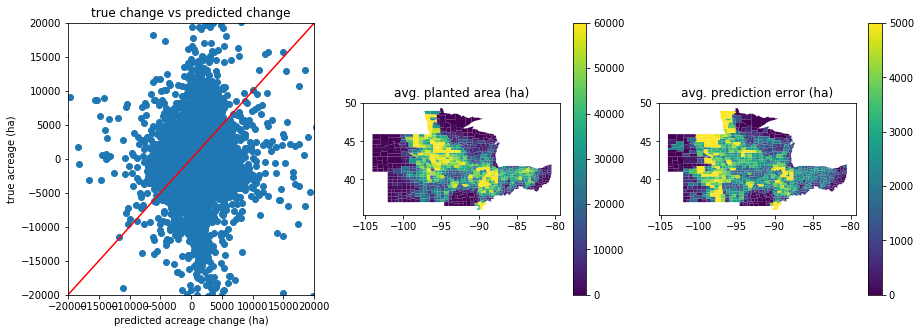

In [188]:
from sklearn import linear_model
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.model_selection import KFold

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 2000)

kf = KFold(n_splits=num_samples-2)
predictions_over_all_states = np.array((0))
true_over_all_states = np.array((0))
district_predicted_change = []
district_actual_change = []
district_actual_planted = []

for train_idxs, test_idxs in kf.split([0]*(num_samples-2)):

    print("doing prediction for %i from %i" % ((test_idxs[0] + 1 + 1995), (test_idxs[0] + 1995)))

    # remove districts that have too small planted areas:
    if FLAGS["minimum_area"] > 0:
        small_district_years = y_full_area[:, :] < FLAGS["minimum_area"]
        small_districts = np.any(small_district_years, axis=1)
        X_flat = X[~small_districts, :, :][:, train_idxs, :].reshape(-1, X.shape[-1])
        y_flat = y[~small_districts, :][:, train_idxs].reshape(-1)
    else:
        X_flat = X[:, train_idxs, :].reshape(-1, X.shape[-1])
        y_flat = y[:, train_idxs].reshape(-1)
        
    total_error = 0.0
    total_error_naive = 0.0
    state_results = []
    
    reg = linear_model.Lasso(alpha=1.0).fit(X_flat, y_flat)
    print("model fitted. score is: %f" % reg.score(X_flat, y_flat))

    for name, state_id in state_ids.items():

        s1, s2 = state_index_map[state_id]
        state_X = X[s1:s2, test_idxs, :].reshape((-1,X.shape[-1]))
        state_y = y[s1:s2, :]
        state_y_full = y_full_area[s1:s2, :]

        county_predictions = reg.predict(np.nan_to_num(state_X))

        # if we are doing a ratio prediction we have to normalize these back to actual deltas
        
        if FLAGS["type"] == "ratio":
            county_predictions = (county_predictions - 1) * state_y_full[:, test_idxs[0] - 1]
        
        true_over_all_states = np.append(true_over_all_states, state_y_full[:, test_idxs[0]] - state_y_full[:, test_idxs[0]-1])
       
        if FLAGS["minimum_area"]:
            # replace these with the required delta to reach the sample mean.
            county_predictions[small_districts[s1:s2]] = np.mean(state_y_full[:, train_idxs][small_districts[s1:s2], :], axis=1) - state_y_full[small_districts[s1:s2], test_idxs[0]-1]

        predicted_sum = np.sum(county_predictions)
        predictions_over_all_states = np.append(predictions_over_all_states, county_predictions)
        
        true_state_sum = np.sum(state_y_full[:, test_idxs[0]] - state_y_full[:, test_idxs[0]-1])
        naive_sum = np.sum(state_y_full[:, test_idxs[0]-2] - state_y_full[:, test_idxs[0]-1])
            
        total_error += np.abs((predicted_sum - true_state_sum)**2)
        total_error_naive += np.abs((naive_sum - true_state_sum)**2)
        error = np.abs(true_state_sum - predicted_sum)
        perc_error = error/np.abs(true_state_sum)*100
        sign_accurate = ((np.sign(predicted_sum) * np.sign(true_state_sum)) > 0)
        state_results.append([(test_idxs[0] + 1 + 1995), 
                              name, predicted_sum, true_state_sum, naive_sum, error, perc_error, sign_accurate])
        
        district_predicted_change += county_predictions.tolist()
        
        district_actual_change += (state_y_full[:, test_idxs[0]] - state_y_full[:, test_idxs[0]-1]).tolist()
  
        district_actual_planted += state_y_full[:, test_idxs[0]].tolist()

    finalcoef = (np.sqrt(total_error/len(state_ids)) / np.sqrt(total_error_naive/len(state_ids)))
    print("our solution was %f as close as a naive extrapolation from y-1, y-2" % finalcoef)
    print("RMSE: %f (vs naive extrapolation RMSE of %f)" % (np.sqrt(total_error/len(state_ids)), np.sqrt(total_error_naive/len(state_ids))))

    state_results_dataframe = pd.DataFrame(state_results, 
                                           columns=["year", 
                                                    "state_name",  
                                                    "predicted_dy", 
                                                    "true_dy", 
                                                    "last_year_dy", 
                                                    "error", 
                                                    "percent_error", 
                                                    "sign_accurate"])
    pd.options.display.float_format = '{:.0f}'.format
    display(state_results_dataframe)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
(ax_scatter, ax_choro_true, ax_choro_error) = axes[0], axes[1], axes[2]
x_0 = y_0 = np.min([np.min(predictions_over_all_states), np.min(true_over_all_states)])
x_1 = y_1 = np.max([np.max(predictions_over_all_states), np.max(true_over_all_states)])

xlim = ylim = 20000

ax_scatter.plot([-xlim, xlim], [-ylim, ylim], c='r')
ax_scatter.scatter(predictions_over_all_states, true_over_all_states)

ax_scatter.set_xlabel("predicted acreage change (ha)")
ax_scatter.set_ylabel("true acreage (ha)")
ax_scatter.set_title("true change vs predicted change")
ax_scatter.set_xlim(-xlim, xlim)
ax_scatter.set_ylim(-ylim, ylim)

ax_choro_true.set_title("avg. planted area (ha)")
ax_choro_error.set_title("avg. prediction error (ha)")

# reshape our logged values and take the average:
number_of_districts_total = len(df_district)

district_error = np.abs(np.array(district_actual_change) - np.array(district_predicted_change))
district_error = np.reshape(district_error, (-1, number_of_districts_total))
district_error = np.mean(district_error, axis=0)

district_actual_planted = np.array(district_actual_planted)
district_actual_planted = np.reshape(district_actual_planted, (-1, number_of_districts_total))
district_actual_planted = np.mean(district_actual_planted, axis=0)

df_district["true_area"] = district_actual_planted
df_district["error_area"] = district_error

# This may cause an error if you have GeoPandas < 0.4.0

cfactor = 0.25
df_district.plot("true_area", cmap='viridis', legend=True, legend_kwds={"loc":"upper right"}, ax=ax_choro_true, vmin=0, vmax=3*ylim)
df_district.plot("error_area", cmap='viridis', legend=True, legend_kwds={"loc":"upper right"}, ax=ax_choro_error, vmin=0, vmax=ylim*cfactor)

plt.show()

## Conclusion

As we can see in the statistics above, there is still a huge amount of variance unexplained by our simple linear model. However, the predictions themselves look less like a cluster that may be fit by a more complex (in terms of being higher order) model and more like they contain a lot of noise. 

However, judging by simple extrapolation from the past two years, we consistently do slightly better than such a baseline and thus there is some advantage gained by modeling over all these features. 

It's important to keep in mind that human-made decisions are variable and influenced by a lot more things than plain economic and environment factors. 